In [1]:
import numpy as np
import math

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from torch.utils.tensorboard import SummaryWriter
from ipywidgets import IntProgress

import torch.multiprocessing as mp

from datetime import datetime

import pdb

from matplotlib import pyplot as plt

from sklearn.model_selection import train_test_split

from sklearn.decomposition import PCA

import data_generator

In [2]:
is_cuda = False
dev = torch.device('cpu')  
if torch.cuda.is_available():
    is_cuda = True
    dev = torch.device('cuda')  

In [3]:
N = 5000
N_train = 3000
N_valid = N - N_train

In [4]:
X, y = data_generator.data_4to1(N)
X, y_perfect = data_generator.data_4to1(N, noise_level=0)

In [5]:
pca = PCA(n_components=1)
pca.fit(X)
X_plot = pca.transform(X)

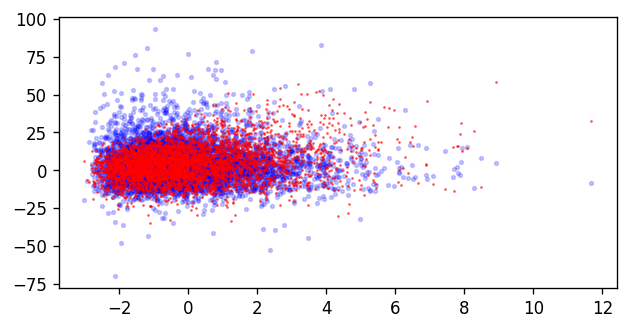

In [6]:
fig,ax = plt.subplots(figsize=(6,3), dpi=120)
plt.scatter(X_plot, y, c='blue', alpha=0.2, s=5)
plt.scatter(X_plot, y_perfect, c='r', alpha=0.7, s=0.3)

In [7]:
X = torch.tensor(X, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.float32)

In [8]:
try:
    X.shape[1]
except:
    X = X.unsqueeze(1)

X_train, X_test, y_train, y_test = train_test_split(
     X, y1, test_size=0.4, random_state=42)

X_train = torch.tensor(X_train, dtype = torch.float32, requires_grad = True, device = dev)
y_train = torch.tensor(y_train,  dtype = torch.float32, requires_grad = True, device = dev)

X_test = torch.tensor(X_test,  dtype = torch.float32, requires_grad = True, device = dev)
y_test = torch.tensor(y_test,  dtype = torch.float32, requires_grad = True, device = dev)

In [9]:
class ArtificialDataset(torch.utils.data.Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y
        return

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        X_i = self.X[idx]
        y_i = self.y[idx]

        return X_i, y_i

In [10]:
dataset = ArtificialDataset(X, y)

data_train, data_valid = torch.utils.data.random_split(
    dataset, [N_train, N_valid])

BATCH_SIZE_LOADER = 64

training_loader = torch.utils.data.DataLoader(
    data_train, batch_size=BATCH_SIZE_LOADER,
    shuffle=True, num_workers=mp.cpu_count())

validation_loader = torch.utils.data.DataLoader(
    data_valid, batch_size=BATCH_SIZE_LOADER,
    shuffle=True, num_workers=mp.cpu_count())

In [11]:
class VariationalLayer(nn.Module):
    def __init__(self, 
                 input_size, output_size,
                 prior_mu, prior_rho,
                 n_samples
                ):
        super().__init__()
        
        # Bias weight
        input_size = input_size + 1
        
        # Defining Prior distribution (Gaussian)
        self.prior_mu = torch.tensor(prior_mu)
        self.prior_rho = torch.tensor(prior_rho)
        
        # Defining Variational class (Gaussian class)
        self.theta_mu = nn.Parameter(
            torch.Tensor(input_size, output_size).uniform_(
                -0.5, 0.5)).float()
        self.theta_rho = nn.Parameter(
            torch.Tensor(input_size, output_size).uniform_(
                -4,-2)).float()
        
        # Defining some constants
        self.logsqrttwopi = torch.log(
            torch.sqrt(2*torch.tensor(torch.pi)))
        self.K = torch.tensor(1)
        
        # Defining number of samples for forward
        self.n_samples = n_samples
    
    def rho_to_sigma(self, theta_rho):
        return torch.log(1 + torch.exp(theta_rho))

    def sample_weight(self, theta_mu, theta_rho):
        w = (theta_mu 
        + self.rho_to_sigma(theta_rho)*torch.randn(
            (self.n_samples, theta_mu.shape[0], theta_mu.shape[1])
        ))
        return w

    def log_prob_gaussian(self, x, mu, rho):
            return (
                - self.logsqrttwopi
                - torch.log(self.rho_to_sigma(rho))
                - ((x - mu)**2)/(2*self.rho_to_sigma(rho)**2)
            ).sum(axis=[1, 2]).mean()
    
    def prior(self, w):
        return self.log_prob_gaussian(
            w, self.prior_mu, self.prior_rho)
        
    def variational(self, w, theta_mu, theta_rho):
        return self.log_prob_gaussian(
            w, theta_mu, theta_rho) 
    
    def kl_divergence_layer(self):
        theta_mu = self.theta_mu
        theta_rho = self.theta_rho
        w = self.sample_weight(theta_mu, theta_rho)
        Q = self.variational(w, theta_mu, theta_rho)
        P = self.prior(w)
        KL = Q - P 
        # CHeck if I need to add mean here
        return KL
    
    def forward(self, x_layer):
        theta_mu = self.theta_mu
        theta_rho = self.theta_rho
        w = self.sample_weight(theta_mu, theta_rho)    
        x_next_layer = torch.bmm(x_layer, w[:, :-1, :]) + w[:,-1,:].unsqueeze(1)
        return x_next_layer
    
    
    
class VariationalNet(nn.Module):
    # Initialize the layers
    def __init__(self, n_samples, input_size, output_size, K):
        super().__init__()
        self.n_samples = n_samples
        self.act1 = nn.ReLU()
        self.act2 = nn.Tanh()
        self.act3 = nn.Sigmoid()
        self.linear1 = VariationalLayer(input_size, 20, 0, 1, n_samples)
        #self.bn = nn.BatchNorm1d(16)
        self.linear2 = VariationalLayer(20, 10, 0, 1, n_samples)
        self.linear3 = VariationalLayer(10, output_size, 0, 1, n_samples)
        self.K = K
    
    # Perform the computation
    def forward(self, x):
        #pdb.set_trace()
        x = torch.unsqueeze(x, 0)
        x = x.expand((self.n_samples, x.shape[1], x.shape[2]))
        x = self.linear1(x)
        #x = self.bn(x)
        x = self.act1(x)
        x = self.linear2(x)
        x = self.act1(x)
        x = self.linear3(x)
        return x
    
    def kl_divergence_NN(self):
        kl = (
            self.linear1.kl_divergence_layer() 
            + self.linear2.kl_divergence_layer()
            + self.linear3.kl_divergence_layer()
        )
        return kl

try:
    X_train.shape[1]
except:
    X_train = X_train.unsqueeze(1)
    X_test = X_test.unsqueeze(1)

In [12]:
n_samples = 10
input_size = 4
output_size = 1

K = 1/50

In [13]:
h = VariationalNet(n_samples, input_size, output_size, K).to(dev)
#h1 = ANN(input_size, output_size).to(dev)
#h2 = BayesianNetwork(1).to(dev)
opt_h = torch.optim.Adam(h.parameters(), lr=0.01)

mse_loss_mean = nn.MSELoss(reduction='mean')
mse_loss_sum = nn.MSELoss(reduction='sum')

#X_train = torch.unsqueeze(X_train, 2)
index = np.random.randint(0, 800, 5)
x_h = X_train[index]
y_h = y1_train[index]
h.forward(x_h)

In [14]:
BATCH_SIZE = 256

In [15]:
def train_one_epoch(epoch_index):
    
    mse_running_loss = 0.
    kl_running_loss = 0.
    
    n = len(training_loader.dataset)

    for i, data in enumerate(training_loader):
        
        x_batch, y_batch = data
        opt_h.zero_grad()

        y_preds = h(x_batch)
        y_preds_mean = y_preds.mean(axis=0).squeeze()

        mse_loss_ = mse_loss_sum(y_preds_mean, y_batch)
        kl_loss_ = h.K*h.kl_divergence_NN()
        
        elbo_loss = mse_loss_ + kl_loss_
        elbo_loss.backward()
        
        opt_h.step()
        
        mse_running_loss += mse_loss_.item()
        kl_running_loss += kl_loss_.item()
        
    mse = mse_running_loss/n
    kl = kl_running_loss/n

    return mse, kl

In [16]:
# Initializing in a separate cell so we can easily add more epochs to the same run
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
epoch_number = 0

EPOCHS = 150

for epoch in range(EPOCHS):
    print('------------------EPOCH {}------------------'.format(
        epoch_number + 1))

    h.train(True)
    avg_mse_loss, avg_kl_loss = train_one_epoch(
        epoch_number)
    avg_loss = avg_mse_loss + avg_kl_loss
    
    h.train(False)
    mse_running_loss_v = 0.0
    kl_running_loss_v = 0.0
    
    n = len(validation_loader.dataset)
    
    for i, vdata in enumerate(validation_loader):
        
        x_val_batch, y_val_batch = vdata

        y_val_preds = h(x_val_batch)
        y_val_preds_mean = y_val_preds.mean(axis=0).squeeze()
        
        mse_loss_ = mse_loss_sum(y_val_preds_mean, y_val_batch)
        kl_loss_ = h.K*h.kl_divergence_NN()
        elbo_loss = mse_loss_ + kl_loss_
        
        mse_running_loss_v += mse_loss_
        kl_running_loss_v += kl_loss_
        
    avg_vmseloss = (mse_running_loss_v / n).item()
    avg_vklloss = (kl_running_loss_v / n).item()
    
    avg_vloss = avg_vmseloss + avg_vklloss
    
    print('MSE LOSS \t train {} valid {}'.format(
        round(avg_mse_loss, 2), round(avg_vmseloss, 2)))
    print('KL LOSS \t train {} valid {}'.format(
        round(avg_kl_loss, 2), round(avg_vklloss, 2)))
    print('ELBO LOSS \t train {} valid {}'.format(
        round(avg_loss, 2), round(avg_vloss, 2)))

    epoch_number += 1

------------------EPOCH 1------------------
MSE LOSS 	 train 201.03 valid 177.62
KL LOSS 	 train 0.27 valid 0.28
ELBO LOSS 	 train 201.31 valid 177.89
------------------EPOCH 2------------------
MSE LOSS 	 train 193.47 valid 177.23
KL LOSS 	 train 0.27 valid 0.27
ELBO LOSS 	 train 193.74 valid 177.5
------------------EPOCH 3------------------
MSE LOSS 	 train 193.07 valid 177.15
KL LOSS 	 train 0.26 valid 0.26
ELBO LOSS 	 train 193.33 valid 177.41
------------------EPOCH 4------------------
MSE LOSS 	 train 192.35 valid 177.44
KL LOSS 	 train 0.26 valid 0.26
ELBO LOSS 	 train 192.61 valid 177.7
------------------EPOCH 5------------------
MSE LOSS 	 train 191.87 valid 177.19
KL LOSS 	 train 0.25 valid 0.26
ELBO LOSS 	 train 192.13 valid 177.45
------------------EPOCH 6------------------
MSE LOSS 	 train 191.91 valid 177.35
KL LOSS 	 train 0.25 valid 0.25
ELBO LOSS 	 train 192.16 valid 177.6
------------------EPOCH 7------------------
MSE LOSS 	 train 191.69 valid 177.25
KL LOSS 	 train 

MSE LOSS 	 train 187.39 valid 182.85
KL LOSS 	 train 0.24 valid 0.24
ELBO LOSS 	 train 187.63 valid 183.09
------------------EPOCH 56------------------
MSE LOSS 	 train 187.03 valid 182.98
KL LOSS 	 train 0.24 valid 0.24
ELBO LOSS 	 train 187.27 valid 183.22
------------------EPOCH 57------------------
MSE LOSS 	 train 186.81 valid 181.8
KL LOSS 	 train 0.24 valid 0.24
ELBO LOSS 	 train 187.05 valid 182.04
------------------EPOCH 58------------------
MSE LOSS 	 train 186.95 valid 183.83
KL LOSS 	 train 0.24 valid 0.25
ELBO LOSS 	 train 187.19 valid 184.08
------------------EPOCH 59------------------
MSE LOSS 	 train 187.03 valid 181.29
KL LOSS 	 train 0.24 valid 0.25
ELBO LOSS 	 train 187.27 valid 181.54
------------------EPOCH 60------------------
MSE LOSS 	 train 186.64 valid 181.69
KL LOSS 	 train 0.24 valid 0.25
ELBO LOSS 	 train 186.88 valid 181.93
------------------EPOCH 61------------------
MSE LOSS 	 train 186.43 valid 182.24
KL LOSS 	 train 0.24 valid 0.25
ELBO LOSS 	 train 18

MSE LOSS 	 train 183.51 valid 184.81
KL LOSS 	 train 0.28 valid 0.29
ELBO LOSS 	 train 183.79 valid 185.1
------------------EPOCH 110------------------
MSE LOSS 	 train 183.37 valid 186.43
KL LOSS 	 train 0.28 valid 0.29
ELBO LOSS 	 train 183.66 valid 186.72
------------------EPOCH 111------------------
MSE LOSS 	 train 183.12 valid 184.25
KL LOSS 	 train 0.28 valid 0.29
ELBO LOSS 	 train 183.41 valid 184.54
------------------EPOCH 112------------------
MSE LOSS 	 train 183.64 valid 185.97
KL LOSS 	 train 0.29 valid 0.29
ELBO LOSS 	 train 183.93 valid 186.26
------------------EPOCH 113------------------
MSE LOSS 	 train 183.57 valid 185.54
KL LOSS 	 train 0.29 valid 0.29
ELBO LOSS 	 train 183.85 valid 185.84
------------------EPOCH 114------------------
MSE LOSS 	 train 182.68 valid 187.7
KL LOSS 	 train 0.29 valid 0.29
ELBO LOSS 	 train 182.97 valid 187.99
------------------EPOCH 115------------------
MSE LOSS 	 train 184.27 valid 185.46
KL LOSS 	 train 0.29 valid 0.29
ELBO LOSS 	 tra

In [27]:
def plot_test_curve(X_test, y_test, h):
    xt = torch.hstack(
    (X_test[:,0], 
     torch.tensor(np.arange(-1.4, -1, 1/500), dtype = torch.float32), 
     torch.tensor(np.arange(1, 1.4, 1/500), dtype = torch.float32)))
    
    plt.scatter(X_test[:,0].detach(), y_test.detach())
    for i in range(0, 100):
        plt.scatter(xt.detach(), 
                    h(xt.unsqueeze(1)).detach().squeeze()[0], 
                    color='r', alpha=0.01)
        plt.ylim([-10, 10])

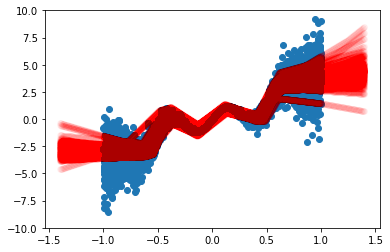

In [28]:
plot_test_curve(validation_loader.dataset.dataset.X,
               validation_loader.dataset.dataset.y,
               h)

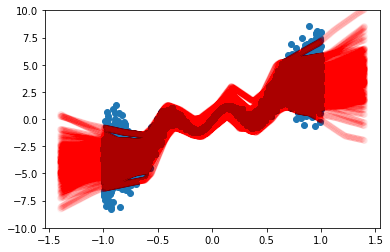

In [20]:
plot_test_curve(validation_loader.dataset.dataset.X,
               validation_loader.dataset.dataset.y,
               h)